In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# global imports
import sys
import time
import pickle
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# local imports
import utils

# general settings  
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc('font', size=14)
plt.rc('legend', fontsize=14)
plt.rc('lines', linewidth=2)
plt.rc('axes', linewidth=2)
plt.rc('axes', edgecolor='k')
plt.rc('xtick.major', width=2)
plt.rc('xtick.major', size=6)
plt.rc('ytick.major', width=2)
plt.rc('ytick.major', size=6)
plt.rc('pdf', fonttype=42)
plt.rc('ps', fonttype=42)

In [2]:
%%time
### parameters
subset_string = 'subset1'
subset = utils.get_subset(subset_string)
print(subset)
# remove PR from states
states = sorted(list(set(utils.states)-{'PR'}))
nstates = len(states)
print('nstates', nstates)
# load data
X_train_s, X_test_s, y_train_s, y_test_s, X_train_t, X_test_t, y_train_t, y_test_t = utils.load_ACSPublicCoverage(subset, states)

['SCHL', 'MAR', 'AGEP', 'SEX', 'CIT', 'RAC1P']
nstates 50
AK AL AR AZ CA CO CT DE FL GA HI IA ID IL IN KS KY LA MA MD ME MI MN MO MS MT NC ND NE NH NJ NM NV NY OH OK OR PA RI SC SD TN TX UT VA VT WA WI WV WY CPU times: total: 1min 48s
Wall time: 1min 48s


In [3]:
# load distances (see calculate_distances.ipynb)
dists = pickle.load( open("results/distances.pkl", "rb" ) )
# restrict to subset and states
dists = { k:{att:d for att, d in v.items() if att in subset} for k, v in dists.items() if k[0] in states and k[1] in states and k[0] != k[1]}

In [4]:
# some exploration of distances
pos = {a:i for i, a in enumerate(subset)}
d_att = [v['d_att'] for k, d in dists.items() for a, v in d.items()]
d_y_cond = [v['d_y_cond'] for k, d in dists.items() for a, v in d.items()]
d_splits = [v['d_splits'] for k, d in dists.items() for a, v in d.items()]
atts = [pos[a] for k, d in dists.items() for a, v in d.items()]

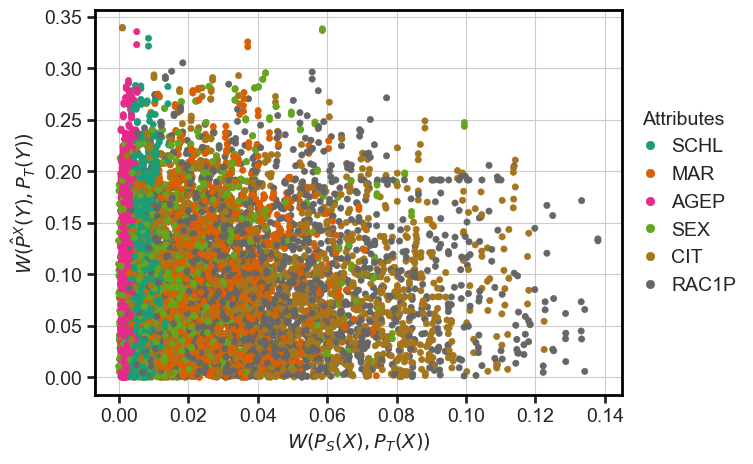

In [15]:
_, ax = plt.subplots(figsize=(4, 5))
scatter = ax.scatter(d_att, d_y_cond, c=atts, linewidths = .5, marker ="o", s=20, cmap="Dark2") # https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.xlabel('$W( P_S(X), P_T(X) )$')
plt.ylabel('$W( \hat{P}^X(Y), P_T(Y) )$')
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 1.7, pos.height])
ax.legend(scatter.legend_elements()[0], subset, title="Attributes", loc='center right', handletextpad=0.1, bbox_to_anchor=(1.25, 0.5))
plt.savefig('fig1.png', bbox_inches='tight', dpi=400)
plt.show()

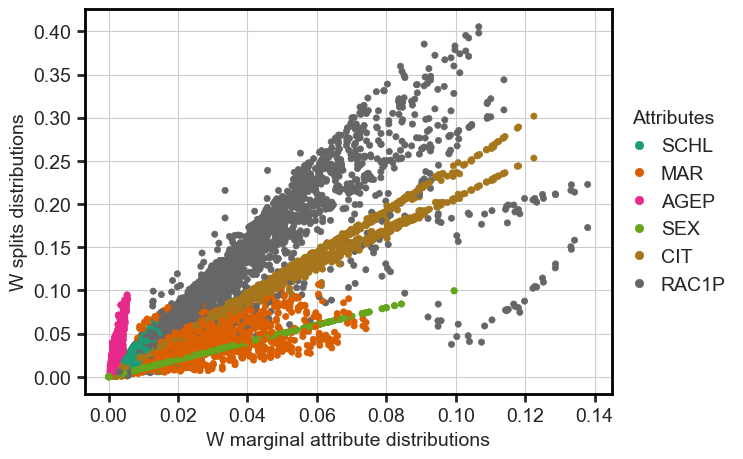

In [6]:
_, ax = plt.subplots(figsize=(4, 5))
scatter = ax.scatter(d_att, d_splits, c=atts, linewidths = .5, marker ="o", s=20, cmap="Dark2") # https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.xlabel('W marginal attribute distributions')
plt.ylabel('W splits distributions')
pos = ax.get_position()
ax.set_position([pos.x0, pos.y0, pos.width * 1.7, pos.height])
ax.legend(scatter.legend_elements()[0], subset, title="Attributes", loc='center right', handletextpad=0.1, bbox_to_anchor=(1.25, 0.5))
plt.show()

In [7]:
%%time
# compute dimensions of analysis
def sim(k, d, agg=np.mean, att=None):
    atts = dists[k]
    if att is None:
        return agg([v[d] for v in atts.values()])
    return atts[att][d]

res = dict()
for k in dists:
    sr, tg = k
    if sr == tg:
        continue
    res[(sr, tg)] = { 'avg_d_att':sim(k, 'd_att'),
                      'avg_d_y_cond':sim(k, 'd_y_cond_est'),
                      'avg_d_splits':sim(k, 'd_splits'),
                      'min_d_y_cond':sim(k, 'd_y_cond_est', np.min)
                    }
avg_d_att = [v['avg_d_att'] for v in res.values()]
avg_d_y_cond = [v['avg_d_y_cond'] for v in res.values()]
avg_d_splits = [v['avg_d_splits'] for v in res.values()]
min_d_y_cond = [v['min_d_y_cond'] for v in res.values()]

KeyError: 'd_y_cond_est'

NameError: name 'avg_d_att' is not defined

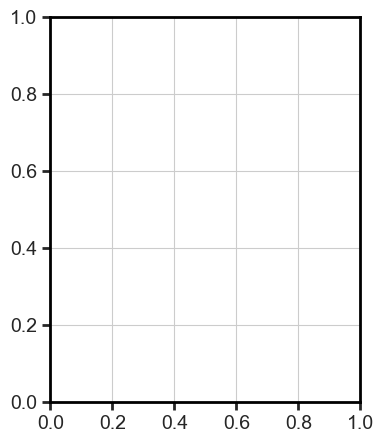

In [8]:
_, ax = plt.subplots(figsize=(4, 5))
scatter = ax.scatter(avg_d_att, avg_d_splits, linewidths = .5, marker ="o", s=20) # https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.xlabel('avg W marginal attribute distributions')
plt.ylabel('min W target and estimated class distr.')
plt.show()

In [ ]:
# run test on model training

In [ ]:
# parameters
max_depth = 8
min_pct = 0.01
source = 'CO'
target = 'AK'
att_td = 'SEX'
# distances
print(dists[(source, target)])
# derived parameters
size = len(X_train_s[source])
min_cases = int(size*min_pct)

In [ ]:
[(c, dists[(source, target)][c]['d_y_cond']) for c in X_train_s[source].columns]

In [ ]:
%%time
# train on target, test on target
clf_t, cm_t, cm_unprotected_t, cm_protected_t = utils.run_test(X_train_s[target], y_train_s[target], X_test_t[target], 
    y_test_t[target], X_td=None, max_depth=max_depth, min_cases=min_cases)

In [ ]:
%%time
# train on source, test on target
clf_s, cm_s, cm_unprotected_s, cm_protected_s = utils.run_test(X_train_s[source], y_train_s[source], X_test_t[target], 
    y_test_t[target], X_td=X_train_t[target], alpha=None, max_depth=max_depth, min_cases=min_cases, y_td=y_train_t[target])

In [ ]:
%%time
# train on source, test on target, alpha=1
alpha = 1
clf1, cm1, cm_unprotected1, cm_protected1 = utils.run_test(X_train_s[source], y_train_s[source], X_test_t[target], 
    y_test_t[target], X_td=X_train_t[target], alpha=alpha, max_depth=max_depth, min_cases=min_cases, 
    y_td=y_train_t[target],att_td=att_td)

In [ ]:
%%time
# train on source, test on target, alpha=0
alpha = 0
clf0, cm0, cm_unprotected0, cm_protected0 = utils.run_test(X_train_s[source], y_train_s[source], X_test_t[target], 
    y_test_t[target], X_td=X_train_t[target], alpha=alpha, max_depth=max_depth, min_cases=min_cases, 
    y_td=y_train_t[target],att_td=att_td)

In [ ]:
# compare accuracies
from utils import cm_metrics

cm_metrics(cm_t)[0], cm_metrics(cm_s)[0], cm_metrics(cm1)[0], cm_metrics(cm0)[0]

In [ ]:
cm_t, cm_s, cm0

In [ ]:
clf_t.tree

In [ ]:
clf_s.w_dist(), clf_s.tree

In [ ]:
clf0.w_dist(), clf0.tree

In [ ]:
# synthetic data experiment: old stuff

import numpy as np
import pandas as pd

def get_y_given_x(x, opt=0):
    y = []
    for v in x:
        if v==1:
            r = np.random.choice(np.arange(0, 2), p=[0.3+opt, 0.7-opt])
        elif v==2:
            r = np.random.choice(np.arange(0, 2), p=[0.4, 0.6])
        elif v==3:
            r = np.random.choice(np.arange(0, 2), p=[0.2, 0.8])
        elif v==4:
            r = np.random.choice(np.arange(0, 2), p=[0.1, 0.9])
        elif v==5:
            r = np.random.choice(np.arange(0, 2), p=[0.8, 0.2])
        else:
            r = np.random.choice(np.arange(0, 2), p=[0.9, 0.1])
        y.append(r)
    return np.array(y)
n = 20000
x = np.random.choice(np.arange(1, 7), size=n, p=[0.1, 0.05, 0.05, 0.2, 0.4, 0.2])
y = get_y_given_x(x)
df1 = pd.DataFrame({"x":x, "y":y})
x = np.random.choice(np.arange(1, 7), size=n, p=[0.5, 0.1, 0.1, 0.1, 0.1, 0.1])
y = get_y_given_x(x, opt=0.0)
df2 = pd.DataFrame({"x":x, "y":y})

In [ ]:
X_train_1, X_test_1, y_train_1, y_test_1 = utils.split_data(df1[["x"]], df1["y"])
X_train_2, X_test_2, y_train_2, y_test_2 = utils.split_data(df2[["x"]], df2["y"])

In [ ]:
def checkatt2(att):
    xs = X_train_1[att]
    xt = X_train_2[att]
    values = sorted(xs.unique())
    ratios = []
    for value in values:
        cond = (xs==value) & (y_train_1==1)
        ps = sum(cond)/sum(xs==value)
        cond = (xt==value) & (y_train_2==1)
        pt = sum(cond)/sum(xt==value)
        ratio = ps/pt
        ratios.append(ratio)
        print(value, ps, pt, ratio)
    print(np.mean(ratios), np.std(ratios))

checkatt2('x')

In [ ]:
from decision_tree_classifier import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from utils import cm_metrics

clf1 = DecisionTreeClassifier(max_depth)
clf1.fit(X_train_1, y_train_1, ["x"], 1)
y_pred = clf1.predict(X_test_2)
cm1 = confusion_matrix(y_test_2, y_pred)
print(cm_metrics(cm1))
clf1.tree

In [ ]:
clf2 = DecisionTreeClassifier(max_depth)
clf2.fit(X_train_1, y_train_1, ["x"], 0, X_train_2, y_train_2)
y_pred = clf2.predict(X_test_2)
cm2 = confusion_matrix(y_test_2, y_pred)
print(cm_metrics(cm2))
clf2.tree

In [ ]:
clf3 = DecisionTreeClassifier(max_depth)
clf3.fit(X_train_2, y_train_2, ["x"], 1)
y_pred = clf3.predict(X_test_2)
cm3 = confusion_matrix(y_test_2, y_pred)
print(cm_metrics(cm3))
clf3.tree